In [29]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
import efficientnet.keras as efn
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import os
import random
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [30]:
IMAGE_SIZE = [224, 224]
weight_size = 224
height_size = 224
batch_size = 32

In [31]:
train_path = './Dataset1/train/'
valid_path = './Dataset1/valid/'
test_path = './Dataset1/test/'

### Data Exploration

In [32]:
# Get a list of classes (groups) in your dataset
classes = [class_name for class_name in sorted(os.listdir(train_path)) if not class_name.startswith('.')]
print("Classes:", classes)

Classes: ['kick', 'punch']


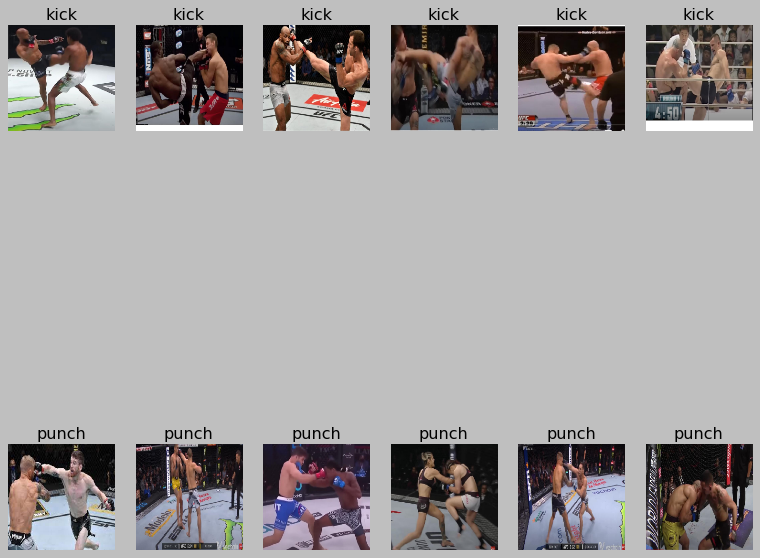

In [33]:
# Number of samples per class to display
num_samples_per_class = 6

# Function to display sample images from each class
def show_sample_images(data_dir, classes, num_samples_per_class):
    plt.figure(figsize=(12,12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = random.sample(os.listdir(class_dir), num_samples_per_class)

        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(weight_size, height_size))

            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Call the function to show sample images from each class
show_sample_images(train_path, classes, num_samples_per_class)


In [34]:
#folders = glob('data/train/*')

In [35]:
#len(folders)

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0,1]
    rotation_range=90,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.4,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.4,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.5,             # Apply shear transformation
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Use the nearest pixel to fill missing areas after augmentation
)

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 250 images belonging to 2 classes.


In [40]:
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 32 images belonging to 2 classes.


In [41]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 85 images belonging to 2 classes.


### Displaying the augmentation of the images

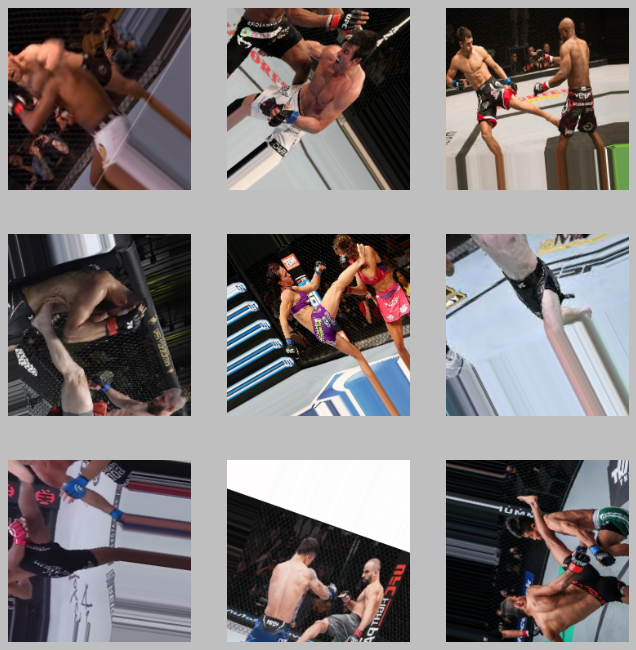

In [42]:
plt.figure(figsize=(10, 10))
images, _ = next(training_set)
for i, image in enumerate(images[: 9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

### MobileNETV2

In [43]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

In [44]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "ReLU"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "ReLU"),
                    Dropout(0.1),
                    Dense(32, activation = "ReLU"),
                    Dropout(0.3),
                    Dense(2, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [45]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [46]:
EPOCHS = 50
hist = model.fit(training_set, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=valid_set)

Epoch 1/50
8/8 [==============================] - 4s 357ms/step - loss: 1.0214 - accuracy: 0.5600 - val_loss: 0.7155 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 2s 278ms/step - loss: 0.9633 - accuracy: 0.5560 - val_loss: 0.6753 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 2s 259ms/step - loss: 0.7961 - accuracy: 0.5840 - val_loss: 0.7507 - val_accuracy: 0.5765 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 2s 259ms/step - loss: 0.7252 - accuracy: 0.6600 - val_loss: 0.7460 - val_accuracy: 0.5647 - lr: 1.0000e-04
Epoch 5/50
8/8 [==============================] - 2s 259ms/step - loss: 0.7763 - accuracy: 0.6360 - val_loss: 0.7630 - val_accuracy: 0.5765 - lr: 1.0000e-04
Epoch 6/50
8/8 [==============================] - 2s 260ms/step - loss: 0.6656 - accuracy: 0.6800 - val_loss: 0.7627 - val_accuracy: 0.5647 - lr: 1.0000e-04
Epoch 7/50
8/8 [==============================] - 2s 261ms/step - loss

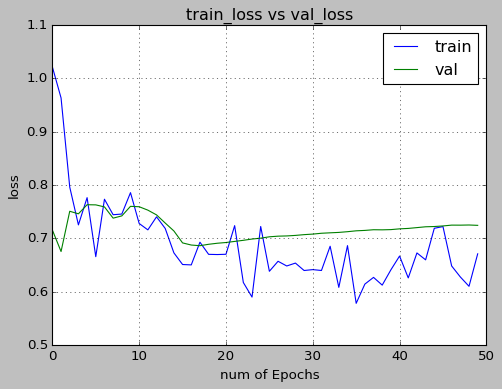

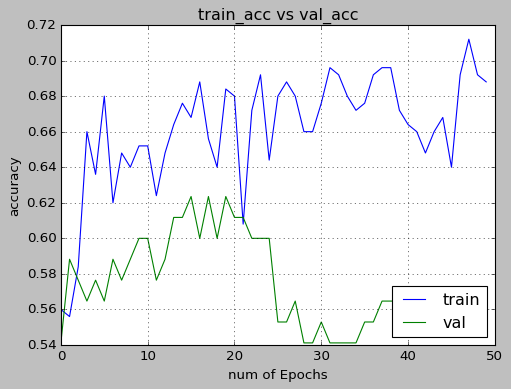

In [47]:
epochs = 50
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

### Model Evaluation

#### Validation accuracy

In [48]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_set, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1833/3858465583.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_set, verbose = 1)


3/3 [==============================] - 0s 74ms/step - loss: 0.7243 - accuracy: 0.5647
Validation Accuracy:  56.47 %


#### Test accuracy

In [49]:
test_loss, test_accuracy = model.evaluate_generator(generator = test_set, verbose = 1)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1833/1841467748.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(generator = test_set, verbose = 1)


1/1 [==============================] - 0s 176ms/step - loss: 0.6556 - accuracy: 0.6562
Test Accuracy:  65.62 %


### Make Predictions

## Efficient NET Model

In [50]:
n_classes=2

In [51]:
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [52]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [53]:
model_history = model.fit_generator(training_set, validation_data = valid_set, callbacks = [early_stop, rlrop],verbose = 1, epochs = 100)

#saving the trained model weights as data file in .h5 format
model.save_weights("kickpunch_efficientnetb0_weights.h5")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1833/1253499279.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(training_set, validation_data = valid_set, callbacks = [early_stop, rlrop],verbose = 1, epochs = 100)


Epoch 1/100
8/8 [==============================] - 15s 1s/step - loss: 0.7261 - accuracy: 0.5520 - val_loss: 0.6822 - val_accuracy: 0.5647 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 6s 683ms/step - loss: 0.6797 - accuracy: 0.6040 - val_loss: 0.6707 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 3/100
8/8 [==============================] - 6s 687ms/step - loss: 0.6717 - accuracy: 0.6320 - val_loss: 0.6578 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 4/100
8/8 [==============================] - 5s 654ms/step - loss: 0.6596 - accuracy: 0.6240 - val_loss: 0.6407 - val_accuracy: 0.6118 - lr: 1.0000e-04
Epoch 5/100
8/8 [==============================] - 5s 641ms/step - loss: 0.6129 - accuracy: 0.6920 - val_loss: 0.6295 - val_accuracy: 0.6353 - lr: 1.0000e-04
Epoch 6/100
8/8 [==============================] - 5s 636ms/step - loss: 0.5633 - accuracy: 0.7000 - val_loss: 0.6224 - val_accuracy: 0.6118 - lr: 1.0000e-04
Epoch 7/100
8/8 [==============================] - 5s 

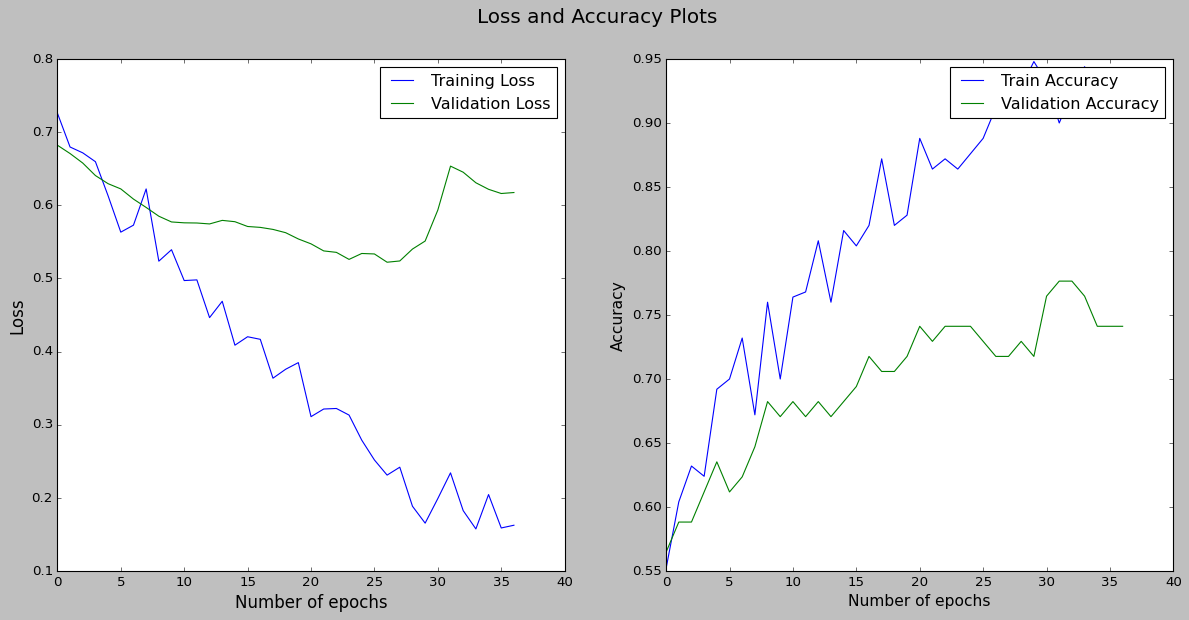

In [54]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

### Model Evaluation

In [55]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_set, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1833/3858465583.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_set, verbose = 1)


3/3 [==============================] - 0s 114ms/step - loss: 0.5222 - accuracy: 0.7176
Validation Accuracy:  71.76 %


### Test Dataset Accuracy

In [56]:
test_loss, test_accuracy = model.evaluate_generator(generator = test_set, verbose = 1)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1833/1841467748.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(generator = test_set, verbose = 1)


1/1 [==============================] - 0s 230ms/step - loss: 0.5937 - accuracy: 0.5312
Test Accuracy:  53.12 %
